In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import graph
import importlib
import math
import matplotlib
import matplotlib.pyplot as plt
import random
import topo
import typing
import utils
import yaml

matplotlib.rc('font', family='Times New Roman', size=16)

In [3]:
sc = topo.Scenario.from_dict(
    yaml.load(open("../../samples/1e3h.yaml", "r").read(), Loader=yaml.Loader)
)
source_selector = graph.SourceSelector({"rasp1": 8, "rasp2": 8, "rasp3": 8})
def unit_size_cb(r: int):
    # if r == 1:
    #     return 10000 * math.pow(10, random.randint(0, 1)) + 100000
    # return 10000 * math.pow(10, random.randint(0, 1)) / math.pow(2, (r-1) / 2)
    return 10000 * math.pow(10, random.randint(0, 1))
gen_args_list = [
    {
        "total_rank": random.randint(7, 7),
        "max_node_per_rank": random.randint(2, 2),
        "max_predecessors": random.randint(2, 2),
        "mi_cb": lambda: 1,
        "memory_cb": lambda: int(2e8),
        "unit_size_cb": unit_size_cb,
        "unit_rate_cb": lambda: random.randint(10, 20),
        "source_hosts": source_selector,
        "sink_hosts": ["cloud1"],
    }
    for _ in range(12)
]
graph_list = [
    graph.GraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
    for idx, gen_args in enumerate(gen_args_list)
]

In [4]:
import all_cloud_cut
import bd_calc
import flow_cut
import greedy_cut

def cut_bd_compare(sc: topo.Scenario, graph_list: typing.List[graph.ExecutionGraph]):
    return (
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, all_cloud_cut.all_cloud_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, flow_cut.flow_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, greedy_cut.greedy_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, greedy_cut.greedy_cut2(sc, graph_list))),
    )

In [5]:
from tqdm.notebook import trange

def run_small_sc(ax, topo_file, labels, source_selector_dict):
    sc = topo.Scenario.from_dict(
        yaml.load(open(topo_file, "r").read(), Loader=yaml.Loader)
    )
    # labels = [4, 8, 12, 16, 20]
    test_round = 100
    flow_box_data = [[] for _ in labels]
    greedy_box_data = [[] for _ in labels]
    greedy2_box_data = [[] for _ in labels]
    base_data = [[] for _ in labels]
    flow_data = [[] for _ in labels]
    greedy_data = [[] for _ in labels]
    greedy2_data = [[] for _ in labels]
    for idx, graph_count in enumerate(labels):
        for _ in trange(test_round, desc="running with {} graphs".format(graph_count)):
            source_selector = graph.SourceSelector(source_selector_dict)
            gen_args_list = [
                    {
                    "total_rank": random.randint(3, 7),
                    "max_node_per_rank": random.randint(1, 3),
                    "max_predecessors": random.randint(1, 2),
                    "mi_cb": lambda: 1,
                    "memory_cb": lambda: int(2e8),
                    "unit_size_cb": unit_size_cb,
                    "unit_rate_cb": lambda: random.randint(10, 20),
                    "source_hosts": source_selector,
                    "sink_hosts": ["cloud1"],
                }
                for _ in range(graph_count)
            ]
            graph_list = [
                graph.GraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
                for idx, gen_args in enumerate(gen_args_list)
            ]
            base, flow, greedy, greedy2 = cut_bd_compare(sc, graph_list)
            base_data[idx].append(base)
            flow_data[idx].append(flow)
            greedy_data[idx].append(greedy)
            greedy2_data[idx].append(greedy2)
            flow_box_data[idx].append(flow / base)
            if flow / base > 1:
                print(flow, base)
            greedy_box_data[idx].append(greedy / base)
            greedy2_box_data[idx].append(greedy2 / base)
    print([utils.avg(*i) / 1e6 for i in base_data])
    print([utils.avg(*i) / 1e6 for i in flow_data])
    print([utils.avg(*i) / 1e6 for i in greedy_data])
    print([utils.avg(*i) / 1e6 for i in greedy2_data])
    # flow_box_data = [i / test_round for i in flow_box_data]
    width = 0.3
    # flow_plot = plt.boxplot(flow_box_data, vert=True, notch=True, positions=[i-width/2 for i in range(1, 6)], widths=width, patch_artist=True)
    flow_plot = ax.violinplot(flow_box_data, vert=True, positions=[i-width for i in range(1, len(labels)+1)], widths=width)
    # for b in flow_plot['boxes']:
    #     b.set_facecolor('lightsalmon')
    # greedy_plot = plt.boxplot(greedy_box_data, vert=True, notch=True, positions=[i+width/2 for i in range(1, 6)], widths=width, patch_artist=True)
    greedy_plot = ax.violinplot(greedy_box_data, vert=True, positions=[i+width for i in range(1, len(labels)+1)], widths=width)
    # for b in greedy_plot['boxes']:
    #     b.set_facecolor('lightblue')
    ax.violinplot(greedy2_box_data, vert=True, positions=[i for i in range(1, len(labels)+1)], widths=width)

running with 4 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 8 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 12 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 16 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 20 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[8.7412, 17.8959, 26.4231, 34.4201, 43.9256]
[6.0242, 12.3456, 19.2432, 26.4065, 38.5707]
[10.8994, 21.61, 33.3322, 42.4871, 50.6165]
[10.6223, 21.2823, 32.1993, 37.7331, 46.6081]


running with 40 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 60 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 80 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 100 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 120 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[88.1212, 132.8278, 175.8291, 221.0174, 263.4227]
[60.9024, 92.3168, 124.6315, 172.3945, 229.2836]
[111.1747, 163.263, 219.7982, 270.8178, 308.3222]
[106.2776, 159.6896, 202.0995, 241.4944, 283.7501]


running with 200 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 300 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 400 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 500 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 600 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


[441.4389, 660.6111, 879.2656, 1096.6108, 1316.6241]
[306.5594, 461.8137, 649.2376, 915.0346, 1248.7922]
[542.2054, 830.8568, 1092.4654, 1299.6508, 1439.6826]
[538.8192, 806.4861, 979.0436, 1187.2265, 1390.1608]


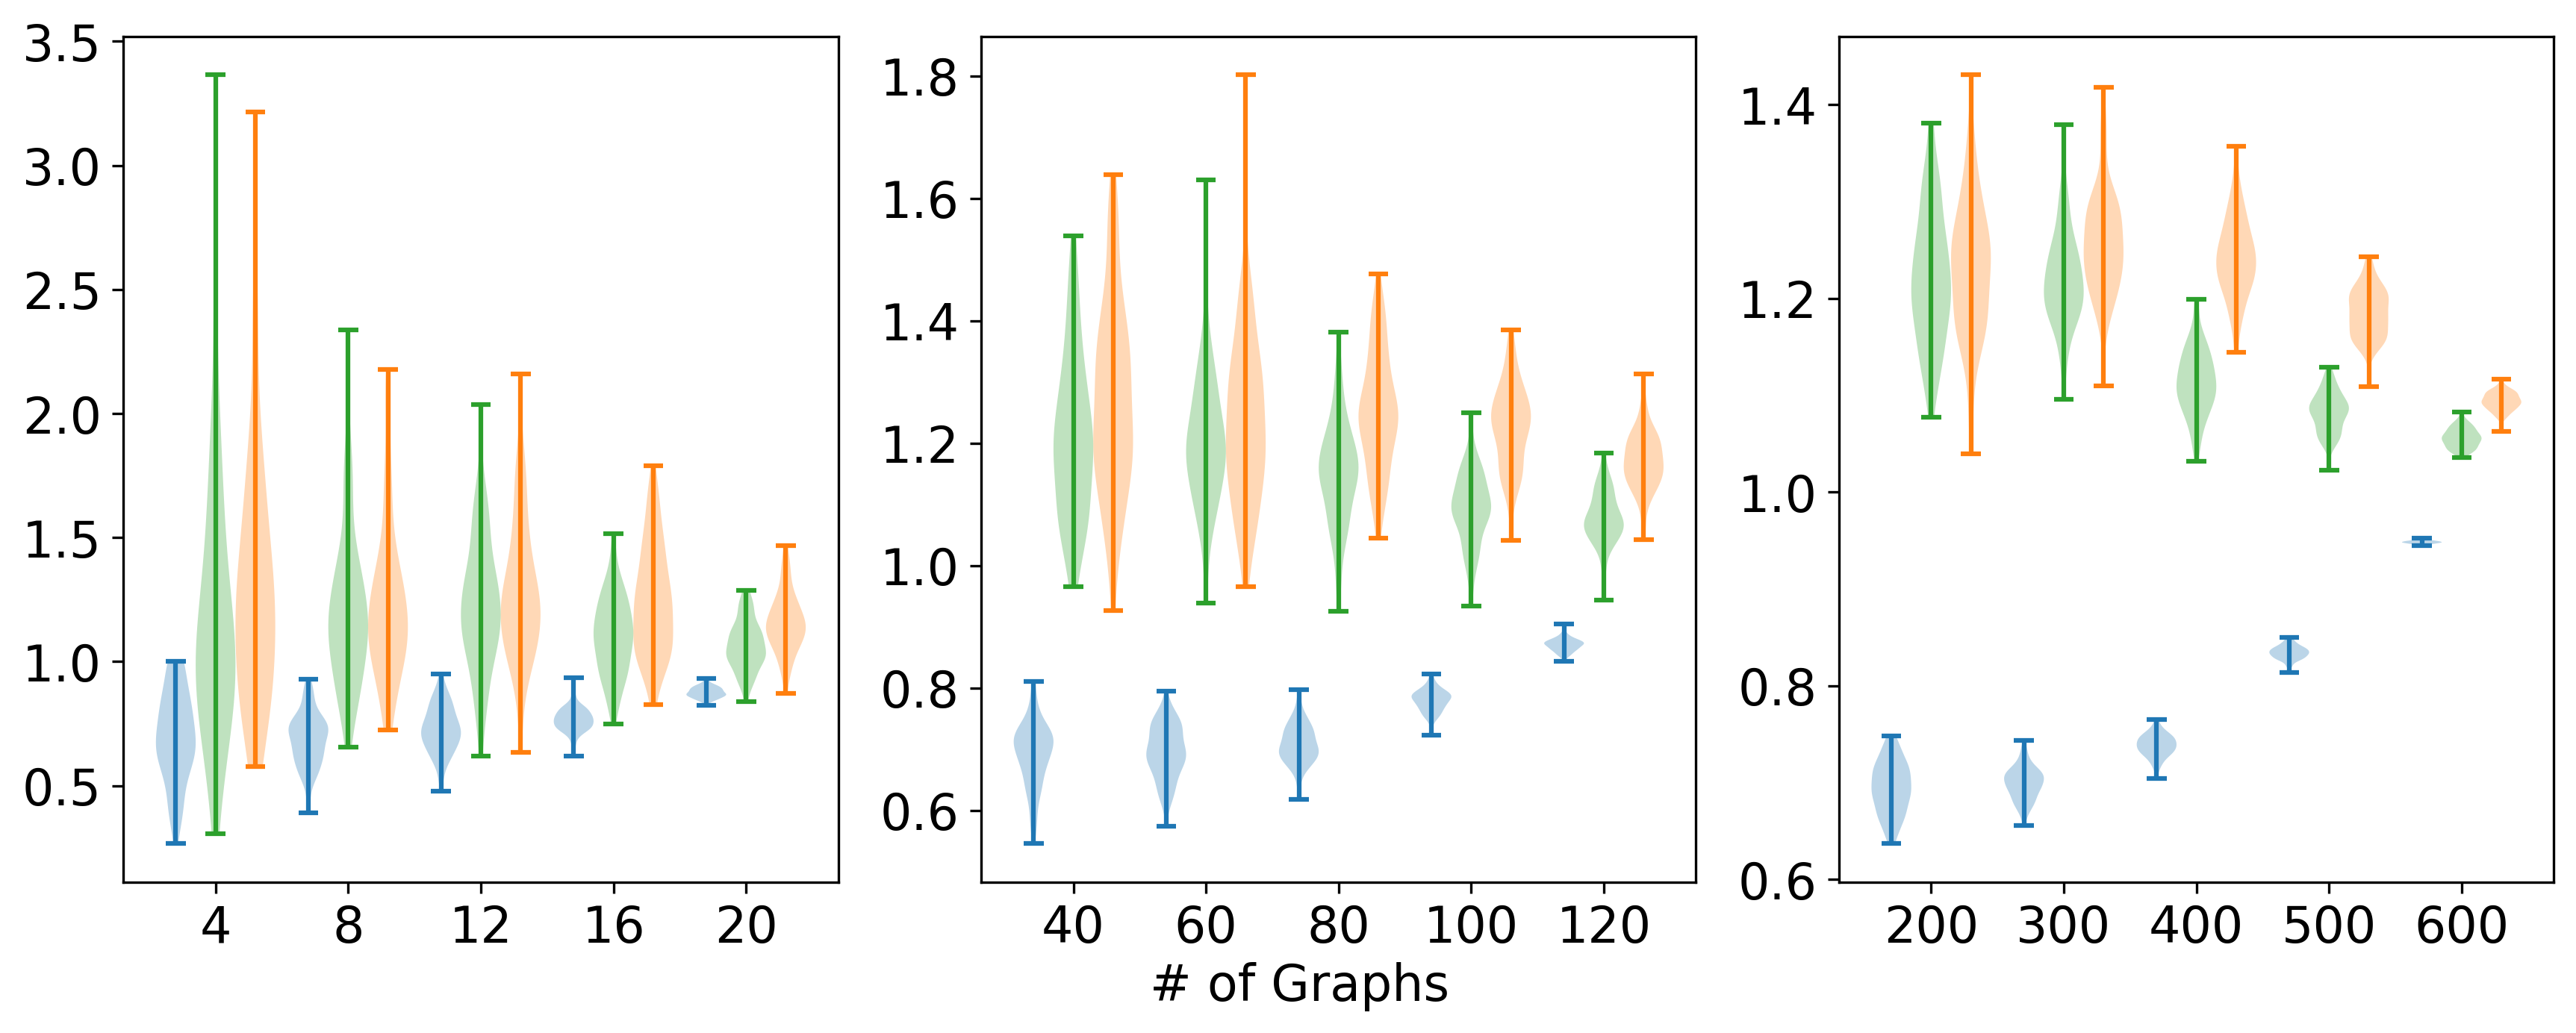

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), dpi=300)
fig.supxlabel('# of Graphs', size='medium')
small_labels = [4, 8, 12, 16, 20]
axes[0].set_xticks([i+1 for i in range(len(small_labels))])
axes[0].set_xticklabels(small_labels)
source_dict = {'rasp1': 8, 'rasp2': 8, 'rasp3': 8}
run_small_sc(axes[0], "../../samples/1e3h.yaml", small_labels, source_dict)

medium_labels = [40, 60, 80, 100, 120]
axes[1].set_xticks([i+1 for i in range(len(medium_labels))])
axes[1].set_xticklabels(medium_labels)
source_dict = {'rasp'+str(i): 8 for i in range(1, 7)}
source_dict.update({'vm'+str(i): 16 for i in range(1, 7)})
run_small_sc(axes[1], "../../samples/1e12h.yaml", medium_labels, source_dict)

large_labels = [200, 300, 400, 500, 600]
axes[2].set_xticks([i+1 for i in range(len(large_labels))])
axes[2].set_xticklabels(large_labels)
source_dict = {'e0rasp'+str(i): 8 for i in range(1, 9)}
source_dict.update({'e1rasp'+str(i): 8 for i in range(1, 9)})
source_dict.update({'e0vm'+str(i): 16 for i in range(1, 9)})
source_dict.update({'e1vm'+str(i): 16 for i in range(1, 9)})
source_dict.update({'e0desktop'+str(i): 32 for i in range(1, 5)})
source_dict.update({'e1desktop'+str(i): 32 for i in range(1, 5)})
run_small_sc(axes[2], "../../samples/1e40h.yaml", large_labels, source_dict)
plt.show()